# Generation Classification with a Convolutional Neural Network

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import ImageFile
from collections import Counter
import pandas as pd

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# custom modules
from models.multibranch_cnn import MultiBranchGenClassifier
from models.cnn import GenClassifier
from models.model_metrics import plot_metrics, get_num_params
from custom_dataset import ModelDataset

## Data PreProcessing

Images are stored in the folder Data/Faces Grouped. File names contain data in the form `[age]_[gender]_[race]_[date&time].jpg`. The age is extracted and used as the label. It is zipped together with the image name.

 Labels are defined in accordance with https://www.beresfordresearch.com/age-range-by-generation/ 


Data is then split into training, validation and test sets. 

In [2]:
def get_label(age):
    """
    Assigns a label to an age.
    """
    labels = {
        'Gen Alpha': 0,
        'Gen Z': 1,
        'Millenial': 2,
        'Gen X': 3,
        'Baby Boomer': 4,
        'Post War': 5,
        'WWII': 6
    }
    
    if 0 <= age <= 11:
        return labels['Gen Alpha']
    elif 12 <= age <= 26:
        return labels['Gen Z']
    elif 27 <= age <= 42:
        return labels['Millenial']
    elif 43 <= age <= 58:
        return labels['Gen X']
    elif 59 <= age <= 77:
        return labels['Baby Boomer']
    elif 78 <= age <= 95:
        return labels['Post War']
    else:
        return labels['WWII']

def get_dataset(data_path):
    """
    Splits the age from the file name to create labels for images.
    """
    # Gets full file names
    file = [file_name for file_name in os.listdir(data_path) if 
              file_name.endswith('.jpg')]
    # Extracts ages from the file name
    label = [get_label(int(label.split('_')[0])) for label in file]
    # Pairs labels with images
    dataset = list(zip(label, file))
    return dataset
    
def get_train_val_test(dataset, split_percent, shuffle=True):
    """
    Split dataset into train/val/test. 
    Shuffles by default.
    """
    if shuffle:
        random.shuffle(dataset)
    
    split_1 = int(len(dataset)*split_percent)
    split_2 = int((len(dataset)-split_1)/2)
    # first 80% of data is for training
    train = dataset[: split_1]
    # next 10% for validation
    val = dataset[split_1 : split_1 + split_2]
    # final 10% for testing
    test = dataset[split_1 + split_2 : (split_1 + (split_2*2))]
    return train, val, test

def dataset_details(dataset, set_type):
    """
    Displays the number of samples in each dataset

    Args:
        dataset (list): list of lables and features
        set_type (str): Type of dataset (train/val/test).
    """
    dataset = pd.DataFrame(dataset, columns=['label', 'image'])
    num_samples = len(dataset)
    class_dict = Counter(dataset['label'].tolist())
    # Count members of each class
    num_gen_alpha = class_dict[0]
    num_gen_z = class_dict[1]
    num_millenial = class_dict[2]
    num_gen_x = class_dict[3]
    num_boomer = class_dict[4]
    num_post_war = class_dict[5]
    num_wwii = class_dict[6]
    

    print('*' + '-' * 20 + '*')
    print(f'|     {set_type:11}    |')
    print('|' + '-' * 20 + '|')
    print(f'| Samples : {num_samples:7}  |')
    print('*' + '-' * 20 + '*')
    print(f'| Gen Alpha : {num_gen_alpha:6} |')
    print(f'| Gen Z     : {num_gen_z:6} |')
    print(f'| Millenial : {num_millenial:6} |')
    print(f'| Gen X     : {num_gen_x:6} |')
    print(f'| Boomer    : {num_boomer:6} |')
    print(f'| Post War  : {num_post_war:6} |')
    print(f'| WWII      : {num_wwii:6} |')
    print('*' + '-' * 20 + '*')
    if set_type == 'Testing':
        print('\n\n')

In [3]:
file_path = 'Data/Faces Grouped'
dataset = get_dataset(file_path)
train, val, test = get_train_val_test(dataset, 0.8)

dataset_details(train, 'Training')
dataset_details(val, 'Validation')
dataset_details(test, 'Testing')

*--------------------*
|     Training       |
|--------------------|
| Samples :   19284  |
*--------------------*
| Gen Alpha :   2798 |
| Gen Z     :   5313 |
| Millenial :   6041 |
| Gen X     :   2856 |
| Boomer    :   1626 |
| Post War  :    606 |
| WWII      :     44 |
*--------------------*
*--------------------*
|     Validation     |
|--------------------|
| Samples :    2411  |
*--------------------*
| Gen Alpha :    387 |
| Gen Z     :    636 |
| Millenial :    766 |
| Gen X     :    358 |
| Boomer    :    191 |
| Post War  :     64 |
| WWII      :      9 |
*--------------------*
*--------------------*
|     Testing        |
|--------------------|
| Samples :    2411  |
*--------------------*
| Gen Alpha :    372 |
| Gen Z     :    641 |
| Millenial :    770 |
| Gen X     :    337 |
| Boomer    :    221 |
| Post War  :     63 |
| WWII      :      7 |
*--------------------*





## Initialise Datasets

The list of labels and features are wrapped in PyTorch Dataset modules. Datasets are defined in their own `.py` file so they can be parallelised by DataLoaders.

This cell also contains a method to view images. This is necessary to analyse the transformations and tweak them if required.

/Users/anthonygavriel/miniconda3/envs/lstm_env/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


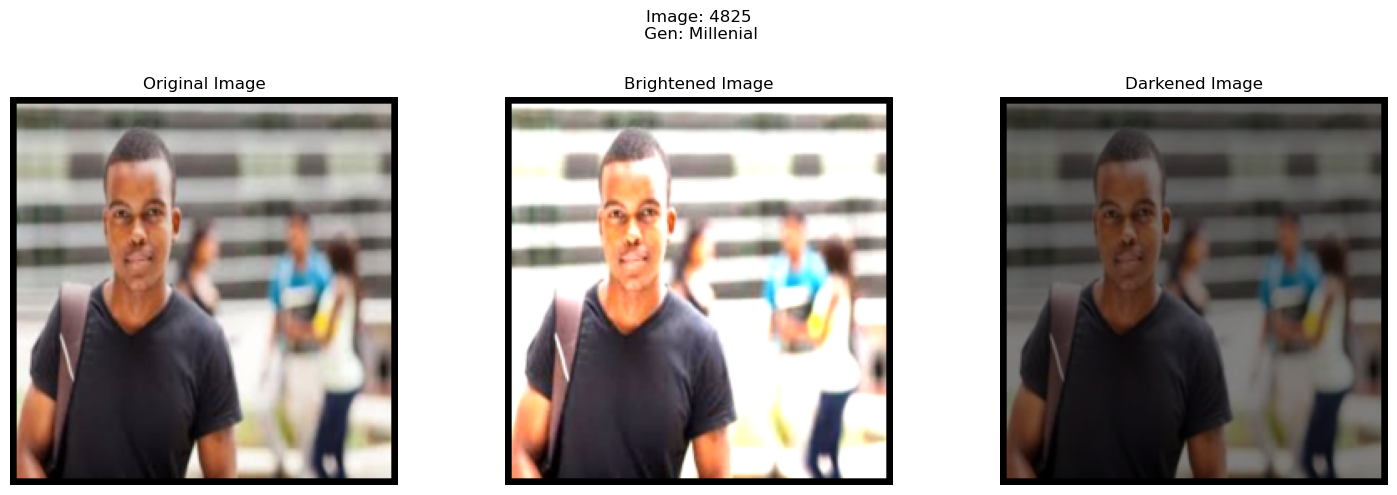

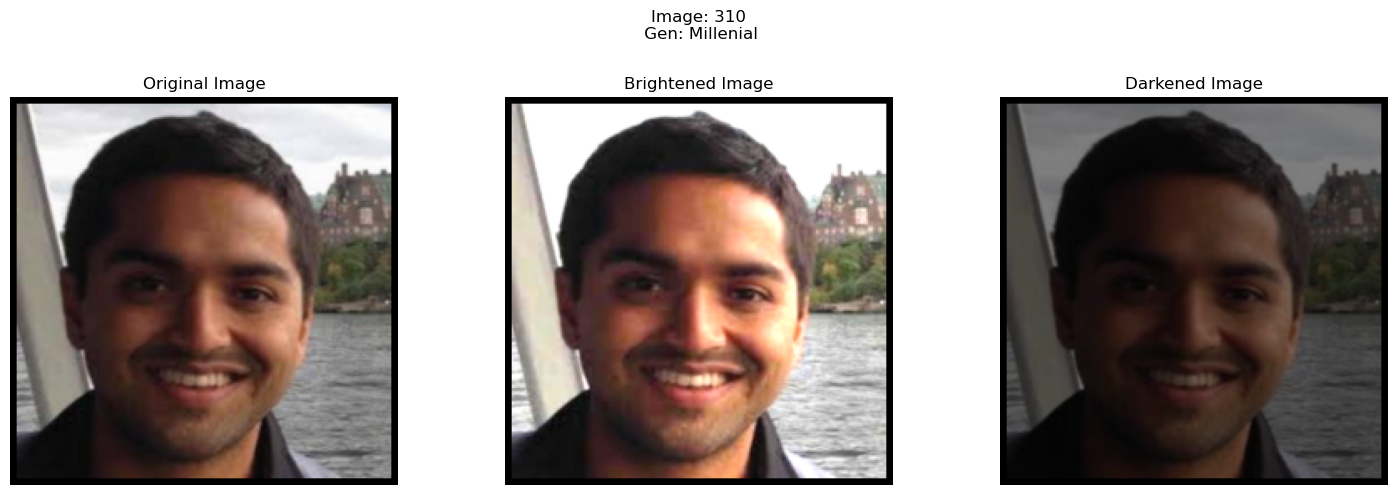

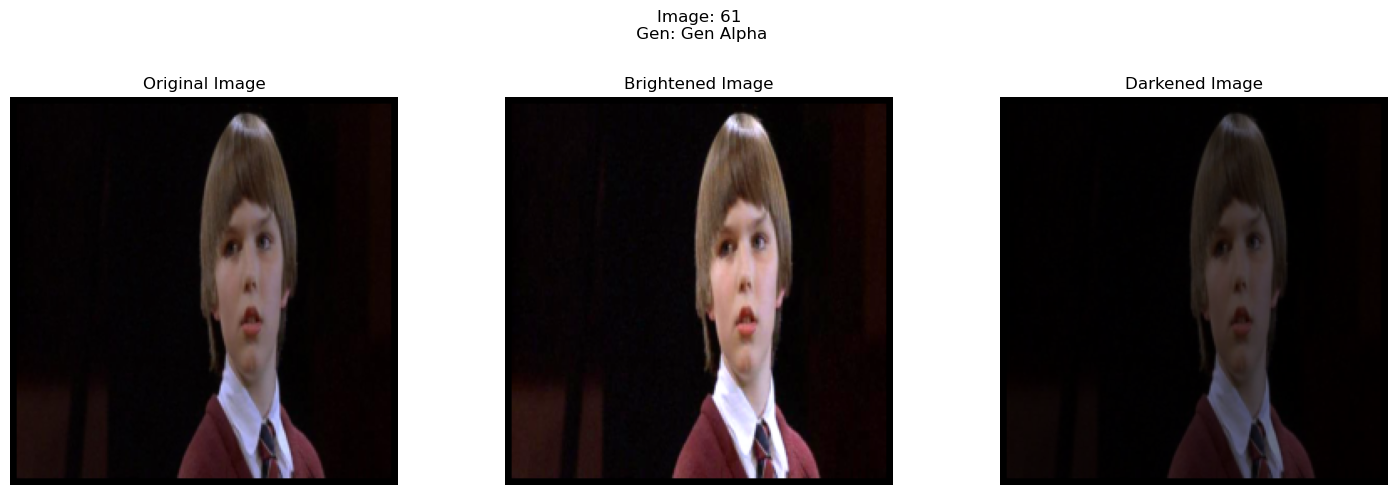

In [4]:
# Create datasets
train_data = ModelDataset(train)
val_data = ModelDataset(val)
test_data = ModelDataset(test)

def denormalize(image):
    """
    Reverses image normalisation so they can be displayed.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image * std + mean

def show_image(data: Dataset):
    """
    Displays labels and images from a random sample.
    """
    AGE_TO_INT = {
        'Gen Alpha': 0,
        'Gen Z': 1,
        'Millenial': 2,
        'Gen X': 3,
        'Baby Boomer': 4,
        'Post War': 5,
        'WWII': 6
    }
    
    idx = random.randint(0, len(data))
    label, image, b_image, d_image = data.__getitem__(idx)
    image_denorm = denormalize(image)
    b_image_denorm = denormalize(b_image)
    d_image_denorm = denormalize(d_image)

    keys = list(AGE_TO_INT.keys())
    gen = keys[label]

    title = f'Image: {idx}\n Gen: {gen}\n\n'
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].imshow(image_denorm.permute(1,2,0))
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    axs[1].imshow(b_image_denorm.permute(1,2,0))
    axs[1].axis('off')
    axs[1].set_title('Brightened Image')
    axs[2].imshow(d_image_denorm.permute(1,2,0))
    axs[2].axis('off')
    axs[2].set_title('Darkened Image')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_image(train_data)
show_image(val_data)
show_image(test_data)

In [5]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            print('Using MPS')
            return torch.device("mps")
    else:
        return torch.device("cpu")
    
device = set_device()

Using MPS


# Run CNN

In [6]:
model = GenClassifier()
model = model.to(device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, verbose=False)

print("{:,} parameters.".format(get_num_params(model)))

6,579 trainable parameters.


In [7]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(val_data, batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=5)

epochs = 10

model_attributes = {
    'criterion': criterion,
    'scheduler': scheduler,
    'batch_size': batch_size,
    'scheduler': scheduler
}

t_acc, t_loss, v_acc, v_loss = model.run_training(
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
)

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------


|    76 /   302 batches | 32.54870130% accurate |
|   152 /   302 batches | 35.07965686% accurate |
|   228 /   302 batches | 35.63045852% accurate |
-------------------------------------------------
| Validation Accuracy   : 39.61012028% accurate |
-------------------------------------------------
| Time Elapsed		: 135.14 seconds	|
-------------------------------------------------

-------------------------------------------------
|		     Epoch 2      		|
-------------------------------------------------
|    76 /   302 batches | 38.10876623% accurate |
|   152 /   302 batches | 38.38848039% accurate |
|   228 /   302 batches | 38.29830786% accurate |
-------------------------------------------------
| Validation Accuracy   : 40.14931564% accurate |
-------------------------------------------------
| Time Elapsed		: 133.92 seconds	|
-------------------------------------------------

-------------------------------------------------
|		     Epoch 3      		|
----------------------------

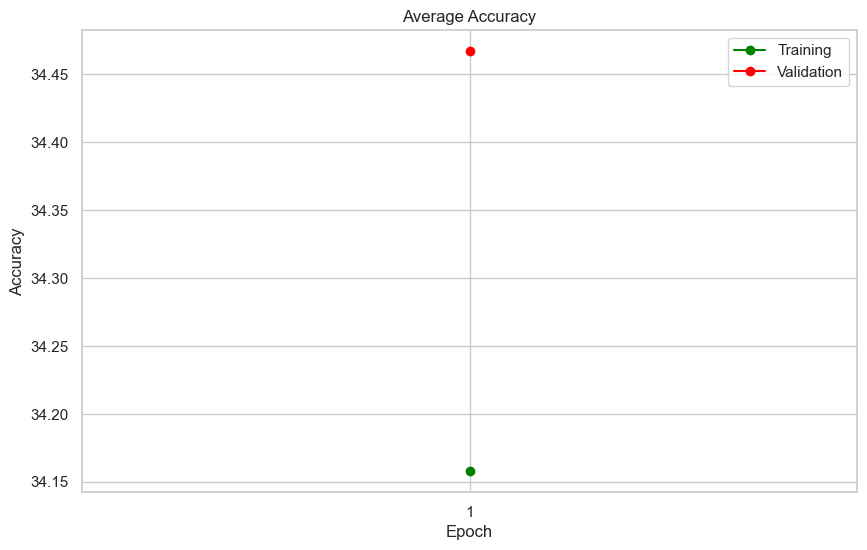

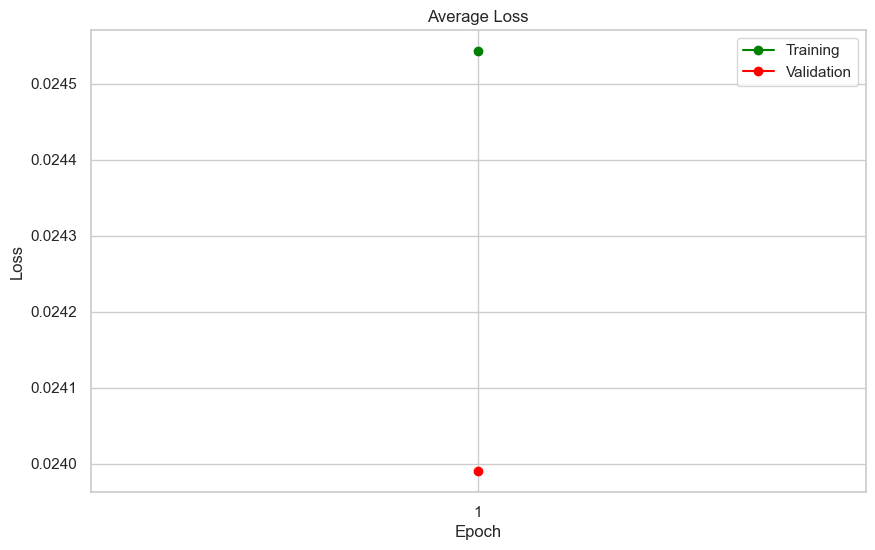

In [8]:
plot_metrics(t_acc, v_acc, 'Accuracy')
plot_metrics(t_loss, v_loss, 'Loss')

# Run Multi-Branch Model

In [7]:
"""
Initialise multi-branch model
"""

mb_model = MultiBranchGenClassifier().to(device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mb_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, verbose=False)

print("{:,} trainable parameters.".format(get_num_params(mb_model)))

Adjusting learning rate of group 0 to 1.0000e-02.
106,275 trainable parameters.


In [8]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

epochs = 1

model_attributes = {
    'criterion': criterion,
    'scheduler': scheduler,
    'batch_size': batch_size,
    'scheduler': scheduler
}

t_acc, t_loss, v_acc, v_loss = mb_model.run_training(
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
)

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------
|    38 /   151 batches | 33.23317308% accurate |
|    76 /   151 batches | 33.24878247% accurate |
|   114 /   151 batches | 33.81793478% accurate |
Adjusting learning rate of group 0 to 1.0000e-02.
-------------------------------------------------
| Validation Accuracy   : 34.67440896% accurate |
-------------------------------------------------
| Time Elapsed		: 510.56 seconds	|
-------------------------------------------------

*-----------------------------------------------*
*		Evaluating Test Data		*
*-----------------------------------------------*
* Test Accuracy		: 34.25964330% accurate *
* Total Training Time	: 9.22 minutes  	*
*-----------------------------------------------*


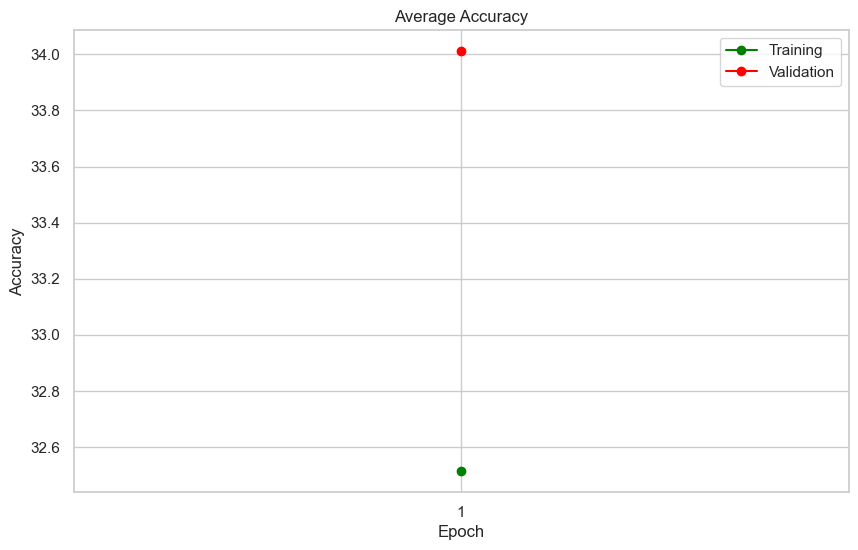

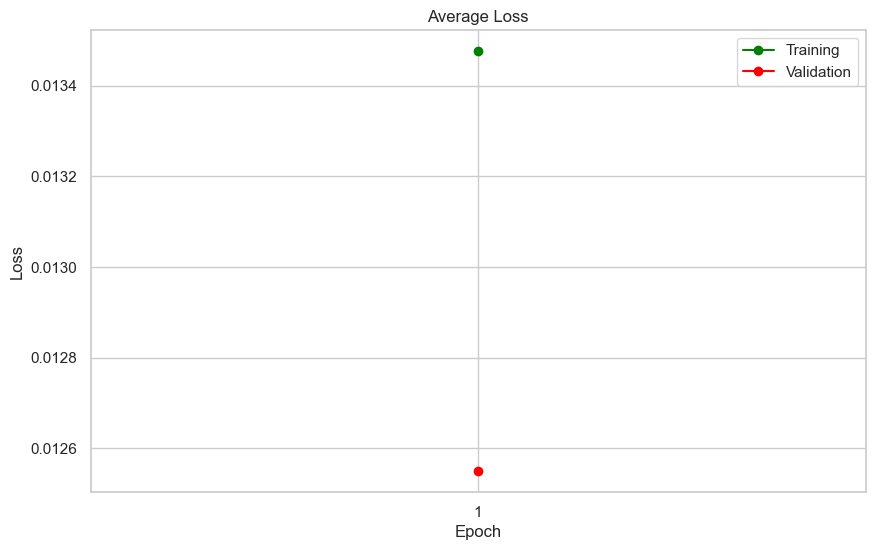

In [10]:
plot_metrics(t_acc, v_acc, 'Accuracy')
plot_metrics(t_loss, v_loss, 'Loss')

In [11]:
def save(model, attributes):
    torch.save({
        'model': model,
        'optimizer_state_dict': attributes['optimizer'].state_dict(),
        'metadata': attributes
    }, 'model/model.pth')
    
save(mb_model, model_attributes)

In [15]:
checkpoint = torch.load('model/model.pth')
loaded_model = checkpoint['model']

optimizer = optim.SGD(loaded_model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

metadata = checkpoint['metadata']


{'criterion': CrossEntropyLoss(), 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'scheduler': <torch.optim.lr_scheduler.StepLR object at 0x28e968a90>, 'batch_size': 128}
None
